In [7]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import pickle
import os

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning - Preprocessing and Evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score

# Machine learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb # Use standard import convention

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Pipeline that handles sampling

Data loaded successfully.

Class distribution before any processing:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

Categorical features identified: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group']
Numerical features identified: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'CustomerLifetimeValue', 'AvgMonthlyCharges', 'ServiceCount', 'HasFamily', 'IsPaperlessBilling', 'IsAutomaticPayment', 'ContractDuration', 'ChargePerTenure', 'charge_ratio']

Training set shape: (5634, 29), Test set shape: (1409, 29)
Training set Churn distribution:
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64
Test set Churn distribution:
Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64

Estimated scale_pos_weight for XGBoost: 2.77

Starti

c:\Users\singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:24:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best parameters found: {'smote__k_neighbors': 7, 'classifier__subsample': 0.8, 'classifier__n_estimators': 300, 'classifier__min_child_weight': 5, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.01, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.8}
Best cross-validation f1 score: 0.6392

Evaluating the best model on the test set...

--- Evaluation Results for XGBoost_SMOTE_RandomSearch (Threshold: 0.50) ---
Accuracy: 0.7779
ROC AUC: 0.8448
F1 Score: 0.6260
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1035
           1       0.57      0.70      0.63       374

    accuracy                           0.78      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.78      0.78      1409



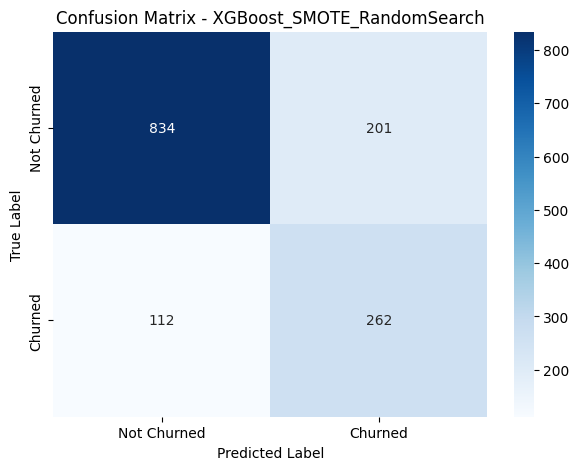

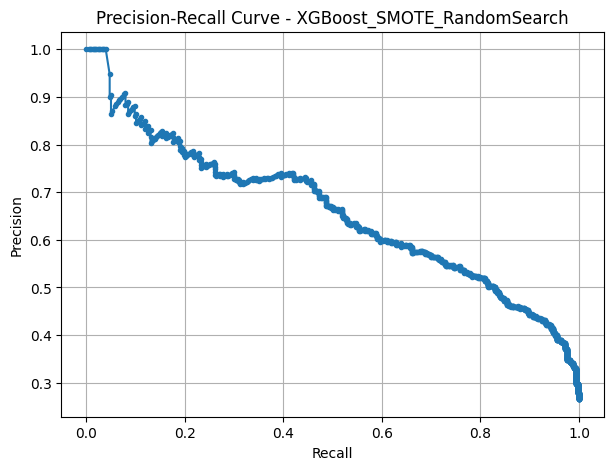


Top 10 Feature Importances:
                        Feature  Importance
45      Contract_Month-to-month    0.297538
27            OnlineSecurity_No    0.054542
10             ContractDuration    0.047908
25  InternetService_Fiber optic    0.037501
36               TechSupport_No    0.037266
29           OnlineSecurity_Yes    0.033336
38              TechSupport_Yes    0.029004
54           tenure_group_0-25%    0.024027
24          InternetService_DSL    0.021450
18               Dependents_Yes    0.020313


C:\Users\singh\AppData\Local\Temp\ipykernel_15988\3476857665.py:236: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20), palette='viridis')


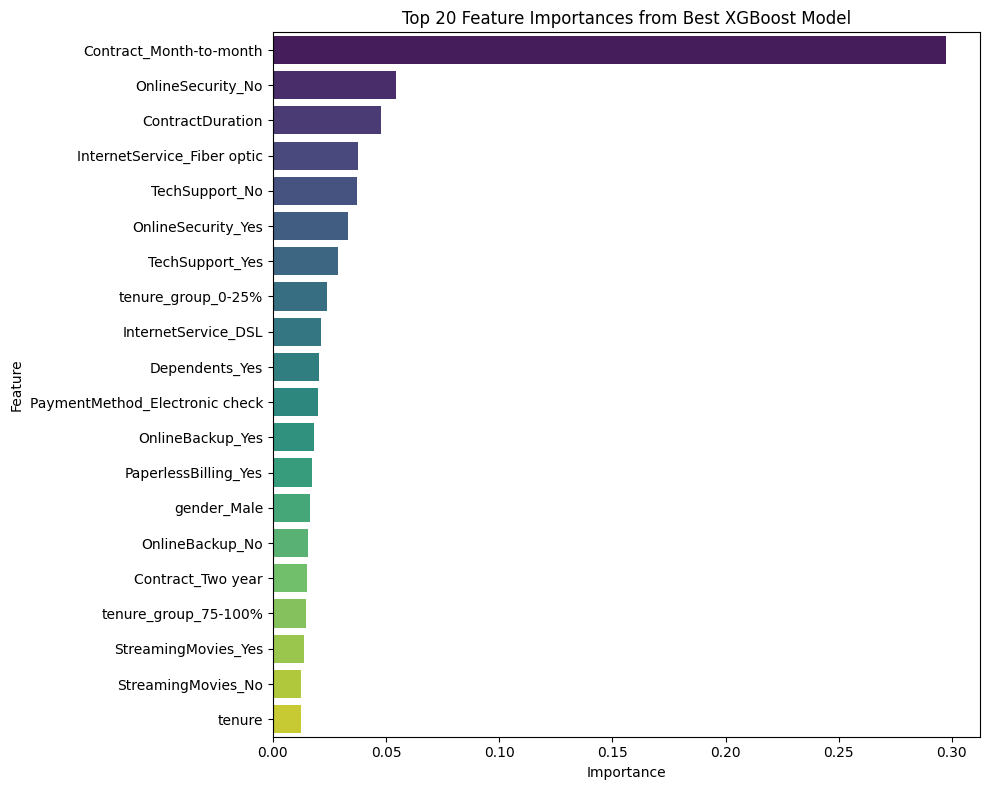


Best model pipeline saved to 'models/tuned_churn_model_xgb_smote.pkl'

--- Model Building Script Finished ---


In [8]:
# --- 1. Load Data ---
# Load data with engineered features (Assuming this path is correct relative to the notebook)
try:
    df = pd.read_csv('C:/churn_prediction/notebooks/data/processed/telco_engineered.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'C:/churn_prediction/notebooks/data/processed/telco_engineered.csv' not found. Please ensure the path is correct.")
    exit() # Or handle the error appropriately

# --- 2. Initial Setup ---
# Check class distribution
print("\nClass distribution before any processing:")
print(df['Churn'].value_counts(normalize=True))

# Define features (X) and target (y)
y = df['Churn']
# Drop target and identifier columns
X = df.drop(['Churn', 'customerID'], axis=1)

# --- 3. Feature Engineering (Example - ensure consistency with 03_feature_engineering.ipynb) ---
# Check if features expected from notebook 03 exist, otherwise recreate them
# Example: Tenure groups (adjust bins/labels as needed)


# --- 4. Identify Feature Types ---
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=np.number).columns.tolist() # Use np.number for broader numeric coverage

# Ensure no overlap and all columns are accounted for (optional check)
# assert len(set(categorical_features) & set(numerical_features)) == 0
# assert set(X.columns) == set(categorical_features) | set(numerical_features)

print(f"\nCategorical features identified: {categorical_features}")
print(f"Numerical features identified: {numerical_features}")

# --- 5. Data Splitting ---
# Stratified split to maintain churn proportion in train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Training set Churn distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test set Churn distribution:\n{y_test.value_counts(normalize=True)}")


# --- 6. Preprocessing Pipelines ---
# Categorical pipeline: Impute missing with most frequent, then OneHotEncode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse=False often easier for XGBoost
])

# Numerical pipeline: Impute missing with median, then scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep any columns not specified (if any)
)


# --- 7. Model Pipeline with SMOTE and XGBoost ---
# Calculate scale_pos_weight for potential use (alternative/complement to SMOTE)
neg_count = y_train[y_train == 0].count()
pos_count = y_train[y_train == 1].count()
estimated_scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1
print(f"\nEstimated scale_pos_weight for XGBoost: {estimated_scale_pos_weight:.2f}")

# Define the model pipeline including preprocessing, SMOTE, and XGBoost
xgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)), # Apply SMOTE to handle imbalance
    ('classifier', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss', # Common eval metric for logistic objective
        use_label_encoder=False, # Recommended to avoid warnings
        random_state=42
        # Consider adding scale_pos_weight here if NOT using SMOTE, or tune it
        # scale_pos_weight=estimated_scale_pos_weight
    ))
])

# --- 8. Hyperparameter Tuning with RandomizedSearchCV ---
# Define the parameter distribution for RandomizedSearchCV
# Reduced grid size compared to the original for faster tuning
param_dist = {
    'smote__k_neighbors': [3, 5, 7], # Example: Tune SMOTE parameter
    'classifier__n_estimators': [100, 200, 300], # Number of trees
    'classifier__max_depth': [3, 5, 7], # Max depth of trees
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2], # Learning rate
    'classifier__subsample': [0.7, 0.8, 0.9, 1.0], # Fraction of samples used per tree
    'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0], # Fraction of features used per tree
    'classifier__gamma': [0, 0.1, 0.2], # Minimum loss reduction required for split
    'classifier__min_child_weight': [1, 3, 5] # Minimum sum of instance weight needed in a child
    # 'classifier__scale_pos_weight': [1, estimated_scale_pos_weight, 2.5] # Uncomment to tune if not using SMOTE or testing combo
}

# Use StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Setup RandomizedSearchCV
# n_iter controls the number of parameter combinations tried (e.g., 50-100)
# Set scoring to 'f1' or 'recall' based on primary objective
random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_dist,
    n_iter=75, # <<< ADJUST THIS NUMBER (e.g., 50, 100, 150) based on time budget
    cv=skf,
    scoring='f1', # Focus on F1-score (balances precision/recall) or use 'recall'
    n_jobs=-1, # Use all available CPU cores
    verbose=2, # Show progress
    random_state=42
)

print("\nStarting RandomizedSearchCV for XGBoost with SMOTE...")
# **Optimization Point:** Add Early Stopping here if desired
# You'd need to modify the pipeline slightly or pass fit_params to random_search.fit()
# Example (conceptual - requires careful integration):
# fit_params = {
#     'classifier__early_stopping_rounds': 10,
#     'classifier__eval_set': [(X_val_processed, y_val)] # Requires creating a validation set WITHIN CV fold
# }
# random_search.fit(X_train, y_train, **fit_params)

random_search.fit(X_train, y_train)

print(f"\nBest parameters found: {random_search.best_params_}")
print(f"Best cross-validation {random_search.scoring} score: {random_search.best_score_:.4f}")

# Get the best estimator (pipeline)
best_model = random_search.best_estimator_


# --- 9. Evaluate Best Model ---
# Define evaluation function
def evaluate_model(model, X_test, y_test, model_name="Model", threshold=0.5):
    # Get raw probabilities first
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Apply threshold to get final predictions
    y_pred = (y_pred_proba >= threshold).astype(int)

    accuracy = np.mean(y_pred == y_test) # Manual accuracy calculation based on threshold
    roc_auc = roc_auc_score(y_test, y_pred_proba) # ROC AUC uses probabilities
    f1 = f1_score(y_test, y_pred) # F1 uses thresholded predictions
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n--- Evaluation Results for {model_name} (Threshold: {threshold:.2f}) ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Classification Report:\n{report}")

    # Plot Confusion Matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churned', 'Churned'],
                yticklabels=['Not Churned', 'Churned'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    # Ensure 'models' directory exists
    os.makedirs('models', exist_ok=True)
    plt.savefig(f'models/{model_name.replace(" ", "_").lower()}_confusion_matrix.png')
    plt.show()

    # Plot Precision-Recall Curve (Useful for threshold tuning)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(7, 5))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.grid(True)
    plt.savefig(f'models/{model_name.replace(" ", "_").lower()}_precision_recall_curve.png')
    plt.show()

    return {
        'accuracy': accuracy, 'roc_auc': roc_auc, 'f1': f1,
        'report': classification_report(y_test, y_pred, output_dict=True),
        'precision': precision, 'recall': recall, 'thresholds': thresholds
    }

# Evaluate the final model using the default 0.5 threshold
print("\nEvaluating the best model on the test set...")
best_results = evaluate_model(best_model, X_test, y_test, "XGBoost_SMOTE_RandomSearch")

# **Optimization Point:** Threshold Tuning
# Analyze the precision-recall curve from best_results
# Find a threshold that gives a desired recall (e.g., find threshold where recall > 0.7)
# desired_recall = 0.7
# pr_thresholds = best_results['thresholds']
# pr_recall = best_results['recall'][:-1] # Exclude the last recall value which corresponds to no prediction
# try:
#     optimal_idx = np.where(pr_recall >= desired_recall)[0][0]
#     optimal_threshold = pr_thresholds[optimal_idx]
#     print(f"\nThreshold for recall >= {desired_recall}: {optimal_threshold:.4f}")
#     # Re-evaluate with the new threshold
#     evaluate_model(best_model, X_test, y_test, "XGBoost_SMOTE_RandomSearch_Tuned", threshold=optimal_threshold)
# except IndexError:
#     print(f"\nCould not find a threshold to achieve recall >= {desired_recall}")


# --- 10. Feature Importance ---
try:
    # Access the classifier step in the best pipeline
    xgb_classifier = best_model.named_steps['classifier']
    importances = xgb_classifier.feature_importances_

    # Get feature names after preprocessing
    # Note: Getting names after one-hot encoding can be complex if categories change
    # This is a common way to retrieve them:
    ohe_categories = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    all_feature_names = numerical_features + list(ohe_categories)

    # Ensure length match (sometimes issues if categories were dropped/handled)
    if len(all_feature_names) == len(importances):
        feature_importances = pd.DataFrame({
            'Feature': all_feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        print("\nTop 10 Feature Importances:")
        print(feature_importances.head(10))

        # Plot top N feature importances
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20), palette='viridis')
        plt.title('Top 20 Feature Importances from Best XGBoost Model')
        plt.tight_layout()
        plt.savefig('models/feature_importances.png')
        plt.show()
    else:
        print("\nWarning: Could not reliably match feature names to importances due to preprocessing complexities. Skipping plot.")
        print(f"Number of names: {len(all_feature_names)}, Number of importances: {len(importances)}")

except Exception as e:
    print(f"\nCould not retrieve feature importances: {e}")


# --- 11. Save the Model ---
model_save_path = 'models/tuned_churn_model_xgb_smote.pkl'
with open(model_save_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"\nBest model pipeline saved to '{model_save_path}'")

print("\n--- Model Building Script Finished ---")
